# Manufacturing Test Data Analysis

This jupyter notebook will be used to perform some analysis of some sample manufacturing test data. The python script in this repository performs the necessary steps to pull down data from a Google Sheet and populate a SQLite database using a pandas dataframe as an intermediary. For convenience, this jupyter notebook starts from a csv file instead of from a Google Sheet. 

The steps are:
1. Read the data from the csv file into a pandas dataframe.
2. Clean up the data.
3. Plot and analyze the data.

Objective: Use the data to determine whether or not a test phase can be eliminated. If a test phase should be kept, explain why.

## Libraries

In [1]:
import unittest
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn

# 1. Read data from csv

In [2]:
# Ingest the csv file into a pandas dataframe.
csv_file_name = "mfg-data.csv"
df = pd.read_csv(csv_file_name)

# Print the number of rows x columns in the dataframe.
print("dataframe shape:", df.shape)

# Check the first rows of the dataframe to see if the pandas import worked.
#df.head()

dataframe shape: (450, 32)


# 2. Cleanup the data

## Cleanup column names

In [3]:
# Cleanup column names to all lowercase with underscores instead of spaces.
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
#print("New column names:")
#df.head()

## Check key values for correctness

In [4]:
# Test the dataframe to make sure it contains correct values in some known positions.
class TestDataframe(unittest.TestCase):
	
	def test_some_column_names(self):
		self.assertEqual(df.columns.values.tolist()[0], "serial_number")
		self.assertEqual(df.columns.values.tolist()[31], "d_stddev_ol")

	def test_some_first_data_row_values(self):
		self.assertEqual(df.at[0,"serial_number"], "4A001H")
		self.assertEqual(df.at[0, "p_cl_2"], "29,335.58")

	def test_some_final_data_row_values(self):
		self.assertEqual(df.at[449, "serial_number"], "3C005V")
		self.assertEqual(df.at[449, "d_stddev_ol"], 0)
		
# Run the unittests
unittest.main(argv=[''], verbosity=1, exit=False)

...
----------------------------------------------------------------------
Ran 3 tests in 0.002s

OK


## Convert numerical data from strings to numbers

In [5]:
# First check what datatypes each column has.
# df.dtypes

In [6]:
# We can see that some of the numerical data is represented as floats and some as objects.
# It's better all the numerical data to floats.
columns_with_numerical_data = ["p_cl_2", "p_avg_cl_25", "p_avg_cl_8", "p_avg_ol", "p_stddev_ol",
                              "f_avg_cl_25", "f_avg_ol", "f_stddev_ol", "d_avg_cl_2", "d_avg_cl_25",
                              "d_avg_cl_8", "d_avg_ol"]

# Remove commas and whitespace
for column in columns_with_numerical_data:
    print(column)
    df[column] = df[column].apply(lambda x : x.strip().replace(',', '')) 
  
print("ok")
df[columns_with_numerical_data] = df[columns_with_numerical_data].astype(float)

p_cl_2
p_avg_cl_25
p_avg_cl_8
p_avg_ol
p_stddev_ol
f_avg_cl_25
f_avg_ol
f_stddev_ol
d_avg_cl_2
d_avg_cl_25
d_avg_cl_8
d_avg_ol
ok


## Convert categorical data from strings to numbers

In [7]:
# For example, plotting and analysis will be easier if we encode "Pass" as 1, "Fail" as 0, and "NaN" as -1
columns_with_categorical_data = ["test_result", "status_cl_2", "status_cl_25", "status_cl_8", "status_ol"]

status_mapping = {"Pass": 1, "Fail": 0}

for column in columns_with_categorical_data:
    print(column)
    df[column] = df[column].map(status_mapping)
    #df[column] = df[column].fillna(-1) # Lets keep the NaNs

#df[columns_with_categorical_data] = df[columns_with_categorical_data].astype(int)
df[columns_with_categorical_data] = df[columns_with_categorical_data].astype(float)


test_result
status_cl_2
status_cl_25
status_cl_8
status_ol


In [8]:
df.head()

,serial_number,date_created,testingsoftwareversion,test_result,status_cl_2,status_cl_25,status_cl_8,status_ol,p_cl_2,p_avg_cl_25,...,f_stddev_cl_8,f_stddev_ol,d_avg_cl_2,d_avg_cl_25,d_avg_cl_8,d_avg_ol,d_stddev_cl_2,d_stddev_cl_25,d_stddev_cl_8,d_stddev_ol
0,4A001H,1/23/2018 10:49,3.2,1.0,1.0,1.0,1.0,1.0,29335.58,29491.29,...,57.42083,45.50565,368.1233,4182.690,1350.583,2383.093,19.25788,17.21346,15.86988,11.74825
1,4A001H,1/23/2018 10:49,3.2,0.0,1.0,0.0,1.0,1.0,29283.49,29633.68,...,61.96784,44.54431,372.3033,4497.020,1339.677,2396.403,16.08281,985.31040,16.53243,11.21949
2,4A001P,1/23/2018 10:15,3.2,1.0,1.0,1.0,1.0,1.0,29305.18,29363.80,...,60.35593,47.61033,412.0700,3849.643,1316.220,2402.773,18.30341,16.72933,14.27912,11.31950
3,4A001M,1/23/2018 10:02,3.2,1.0,1.0,1.0,1.0,1.0,29281.21,29302.74,...,52.70877,52.20287,319.4800,3205.407,1072.523,2387.513,15.92340,30.93753,13.09100,12.09733
4,4A001K,1/23/2018 9:47,3.2,1.0,1.0,1.0,1.0,1.0,29390.77,29342.95,...,60.10137,41.39107,348.8233,3549.727,1196.373,2405.407,12.25349,18.39503,13.93871,10.74339


## Convert timestamps to pandas.timestamp

In [9]:
df["date_created"] = pd.to_datetime(df["date_created"])    
df.head()

,serial_number,date_created,testingsoftwareversion,test_result,status_cl_2,status_cl_25,status_cl_8,status_ol,p_cl_2,p_avg_cl_25,...,f_stddev_cl_8,f_stddev_ol,d_avg_cl_2,d_avg_cl_25,d_avg_cl_8,d_avg_ol,d_stddev_cl_2,d_stddev_cl_25,d_stddev_cl_8,d_stddev_ol
0,4A001H,2018-01-23 10:49:00,3.2,1.0,1.0,1.0,1.0,1.0,29335.58,29491.29,...,57.42083,45.50565,368.1233,4182.690,1350.583,2383.093,19.25788,17.21346,15.86988,11.74825
1,4A001H,2018-01-23 10:49:00,3.2,0.0,1.0,0.0,1.0,1.0,29283.49,29633.68,...,61.96784,44.54431,372.3033,4497.020,1339.677,2396.403,16.08281,985.31040,16.53243,11.21949
2,4A001P,2018-01-23 10:15:00,3.2,1.0,1.0,1.0,1.0,1.0,29305.18,29363.80,...,60.35593,47.61033,412.0700,3849.643,1316.220,2402.773,18.30341,16.72933,14.27912,11.31950
3,4A001M,2018-01-23 10:02:00,3.2,1.0,1.0,1.0,1.0,1.0,29281.21,29302.74,...,52.70877,52.20287,319.4800,3205.407,1072.523,2387.513,15.92340,30.93753,13.09100,12.09733
4,4A001K,2018-01-23 09:47:00,3.2,1.0,1.0,1.0,1.0,1.0,29390.77,29342.95,...,60.10137,41.39107,348.8233,3549.727,1196.373,2405.407,12.25349,18.39503,13.93871,10.74339


# 3. Data Analysis

## For each column, how many missing or strange values are there?

In [16]:
# We can use "describe" to show a lot of 
df.describe()

,testingsoftwareversion,test_result,status_cl_2,status_cl_25,status_cl_8,status_ol,p_cl_2,p_avg_cl_25,p_avg_cl_8,p_avg_ol,...,f_stddev_cl_8,f_stddev_ol,d_avg_cl_2,d_avg_cl_25,d_avg_cl_8,d_avg_ol,d_stddev_cl_2,d_stddev_cl_25,d_stddev_cl_8,d_stddev_ol
count,442.00000,449.000000,448.000000,439.000000,445.000000,438.000000,450.000000,450.000000,450.000000,450.000000,...,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000
mean,3.16267,0.634744,0.845982,0.808656,0.761798,0.910959,28799.197157,28276.903652,28721.657367,29524.249059,...,60.467758,48.716788,1235.547416,5053.995682,2221.062660,2693.984165,27.889232,120.312266,19.559376,19.542673
std,0.30807,0.482039,0.361369,0.393808,0.426463,0.285129,3378.416414,5189.755529,4025.079281,5257.695063,...,54.313106,192.998113,3611.996076,3451.207699,3408.849674,2723.632552,116.693975,224.798688,36.967677,130.165722
min,-3.20000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1171.640000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.20000,0.000000,1.000000,1.000000,1.000000,1.000000,29291.465000,29312.572500,29389.030000,30641.955000,...,50.419602,35.725210,337.739200,3583.889000,1192.574750,2402.853000,15.549385,16.148933,14.172213,9.896221
50%,3.20000,1.000000,1.000000,1.000000,1.000000,1.000000,29333.950000,29405.045000,29430.550000,30654.435000,...,55.875610,39.649770,450.998350,4160.360000,1448.913500,2421.101500,17.120565,22.545610,15.557350,10.800455
75%,3.20000,1.000000,1.000000,1.000000,1.000000,1.000000,29373.927500,29469.155000,29468.365000,30666.375000,...,61.902687,44.539195,579.698325,5594.235000,1877.993250,2438.877000,18.937040,45.488245,17.288137,11.778422
max,3.20000,1.000000,1.000000,1.000000,1.000000,1.000000,29617.930000,29663.160000,29584.620000,30684.300000,...,851.725800,4087.230000,36387.250000,36391.400000,36395.960000,36346.890000,2324.910000,1180.899000,502.569800,2086.337000


## Are the different tests correlated?

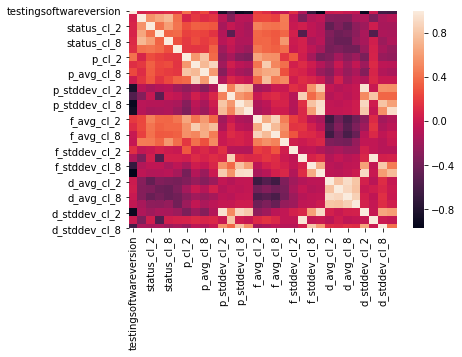

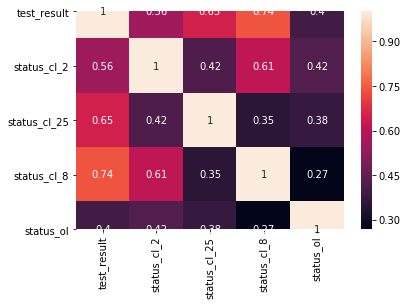

In [11]:
# TODO
big_correlation_matrix = df.corr()
sn.heatmap(big_correlation_matrix, annot=False)
plt.show()

# Correlation heatmap of passes and fails for the 5 test categories
# If a certain test is not highly correlated with overall test success,
# the test might be a good candidate for removal.

# I have a hunch that we can flip the original question around,
# and think of it in a different way. Which variables are GOOD predictors
# of an overall failure, and which variables are BAD predictors?

columns_with_categorical_data = ["test_result", "status_cl_2", "status_cl_25", "status_cl_8", "status_ol"]
small_correlation_matrix = df[columns_with_categorical_data].corr()
sn.heatmap(small_correlation_matrix, annot=True)
plt.show()
#print(small_correlation_matrix)

## Heatmap Analysis

In the above heatmaps, we represent the correlation of each individual test phase status with each other. 
The scale of these heatmaps is from +1 (perfectly correlated) as can be seen in the diagonal line, to -1 (perfectly negatively correlated). In the middle lies 0.0 which means no correlation.


Of the 4 phases, we can see that "status_cl_8" has the highest correlation with the overall "test_result" and "status_ol" has the lowest correlation with the overall "test_result". Written another way, "status_cl_8" is the best predictor of "test_result" wheras "status_ol" is a bad predictor of "test_result".

Looking at the correlation between the phases themselves, we can see that the lowest correlation value (0.27) is between "status_cl_8" and "status_ol". This tells us that the result of one of these phase tests is a bad predictor of the result of the other phase test.

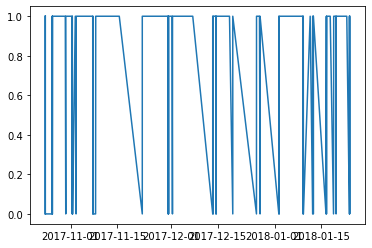

In [15]:
# Another variable I am curious about is the timestamp.
# Is there any correlation between when a test was performed and the results of the test?
# Maybe a heatmap wont work, maybe a histogram instead?

# test_result vs date_created
plt.plot(df["date_created"], df["test_result"])
plt.show()

# This data is a bit noisy. Since the data spans from October 2017 to January 2018, we can bin the test data
# into a histogram separated by Qtr (3-months.)

#Plot Histogram of "total_bill" with bins parameters
#plt.hist("test_result")

## What variables are amiss when a test fails?

In [23]:
# TODO
# For a certain serial_number, plot how some process variables p, d, f change over time.

# Print out the last rows
df.head()

,serial_number,date_created,testingsoftwareversion,test_result,status_cl_2,status_cl_25,status_cl_8,status_ol,p_cl_2,p_avg_cl_25,...,f_stddev_cl_8,f_stddev_ol,d_avg_cl_2,d_avg_cl_25,d_avg_cl_8,d_avg_ol,d_stddev_cl_2,d_stddev_cl_25,d_stddev_cl_8,d_stddev_ol
0,4A001H,2018-01-23 10:49:00,3.2,1.0,1.0,1.0,1.0,1.0,29335.58,29491.29,...,57.42083,45.50565,368.1233,4182.690,1350.583,2383.093,19.25788,17.21346,15.86988,11.74825
1,4A001H,2018-01-23 10:49:00,3.2,0.0,1.0,0.0,1.0,1.0,29283.49,29633.68,...,61.96784,44.54431,372.3033,4497.020,1339.677,2396.403,16.08281,985.31040,16.53243,11.21949
2,4A001P,2018-01-23 10:15:00,3.2,1.0,1.0,1.0,1.0,1.0,29305.18,29363.80,...,60.35593,47.61033,412.0700,3849.643,1316.220,2402.773,18.30341,16.72933,14.27912,11.31950
3,4A001M,2018-01-23 10:02:00,3.2,1.0,1.0,1.0,1.0,1.0,29281.21,29302.74,...,52.70877,52.20287,319.4800,3205.407,1072.523,2387.513,15.92340,30.93753,13.09100,12.09733
4,4A001K,2018-01-23 09:47:00,3.2,1.0,1.0,1.0,1.0,1.0,29390.77,29342.95,...,60.10137,41.39107,348.8233,3549.727,1196.373,2405.407,12.25349,18.39503,13.93871,10.74339


In [43]:
# Finally, I also want to see a list of all the serial numbers which failed the test
# and the date each was created. # see the last results / data for a particular serial number.

i = 0
while i < df.shape[0]:
    if df["test_result"][i] == 0:
        print(df["serial_number"][i] + " . . . " + str(df["date_created"][i]))
    i += 1

4A001H . . . 2018-01-23 10:49:00
4A001F . . . 2018-01-23 08:53:00
4A000M . . . 2018-01-19 09:15:00
4A000N . . . 2018-01-18 15:00:00
4A000T . . . 2018-01-16 12:33:00
4A000X . . . 2018-01-16 08:58:00
4A000X . . . 2018-01-12 14:09:00
4A0017 . . . 2018-01-12 09:09:00
4A0017 . . . 2018-01-12 09:09:00
4A000D . . . 2018-01-09 14:49:00
4A000D . . . 2018-01-09 14:49:00
4A000V . . . 2018-01-09 11:52:00
3H001J . . . 2018-01-02 09:02:00
3H001J . . . 2018-01-02 09:02:00
3M002Z . . . 2018-01-02 06:27:00
3M002Z . . . 2018-01-02 06:27:00
3M002U . . . 2017-12-27 15:37:00
3M002U . . . 2017-12-27 15:37:00
3M002U . . . 2017-12-27 15:37:00
3M0033 . . . 2017-12-26 13:48:00
3M001D . . . 2017-12-19 11:46:00
3M002F . . . 2017-12-14 13:10:00
3M0029 . . . 2017-12-14 10:38:00
3M002T . . . 2017-12-13 15:05:00
3M002T . . . 2017-12-13 15:05:00
3M002T . . . 2017-12-13 15:05:00
3M002T . . . 2017-12-13 15:05:00
3M002T . . . 2017-12-13 15:05:00
3M002T . . . 2017-12-13 15:05:00
3M0038 . . . 2017-12-13 11:49:00
3M0038 . .